In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Input, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
import cv2
import numpy as np

image = cv2.imread("data\\Training\\glioma_tumor\\gg (1).jpg", cv2.IMREAD_GRAYSCALE)

# Eşikleme işlemi (örneğin Otsu yöntemi)
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Bağlantılı bileşen analizi
num_labels, labels = cv2.connectedComponents(binary_image, connectivity=4)

# Sonuçları görüntüleme
print(f"Number of connected components: {num_labels}")

# Her bileşeni farklı bir renkte gösterme
# Normalizasyon ve renklendirme
label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
colored_image = cv2.merge([label_hue, blank_ch, blank_ch])
colored_image = cv2.cvtColor(colored_image, cv2.COLOR_HSV2BGR)
colored_image[label_hue == 0] = 0

# CLAHE uygulama
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image3 = clahe.apply(image.astype(np.uint8))

# 3 kanallı RGB benzeri yapıya dönüştürme
image4 = np.expand_dims(image, axis=-1)  # Gri tonlama kanal boyutu
image5 = np.repeat(image4, 3, axis=-1)  # 3 kanallı RGB benzeri şekle dönüştürme (224, 224, 3)

# Gürültü azaltma
image6 = cv2.GaussianBlur(image, (5, 5), 0)

images = [image, colored_image, image3, image4, image5, image6]


Number of connected components: 37


In [32]:
print(image.shape)

(512, 512)


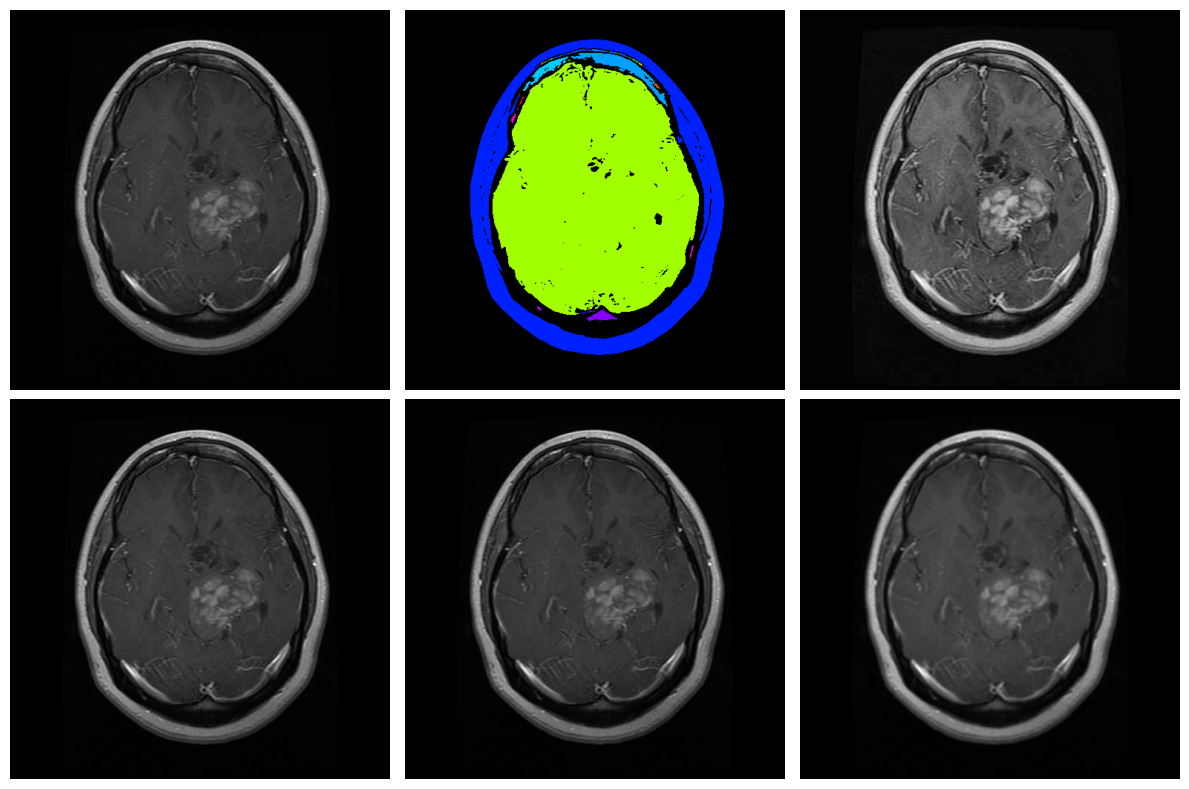

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i < len(images):  # Sınır kontrolü
        ax.imshow(images[i], cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [34]:
train_dir = "/data/Training"
validation_dir = "/data/validation"
test_dir = "/data/Testing"


In [35]:
def custom_preprocessing(image):
    # Normalize (rescale)
    image = image / 255.0

    # Histogram Equalization (CLAHE)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Grayscale if needed
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image.astype(np.uint8))

    # Reshape back to add channel dimension (1 for grayscale or 3 for RGB)
    image = np.expand_dims(image, axis=-1)  # For grayscale channel dimension
    image = np.repeat(image, 3, axis=-1)  # Convert to 3-channel RGB-like shape (224, 224, 3)

    # Blur to reduce noise
    image = cv2.GaussianBlur(image, (5, 5), 0)

    return image.astype('float32') / 255.0

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    #preprocessing_function=custom_preprocessing
)

validation_datagen = ImageDataGenerator(
    rescale=1./255, 
    #preprocessing_function=custom_preprocessing
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    #preprocessing_function=custom_preprocessing
)

In [37]:
train_generator = train_datagen.flow_from_directory(
    "./"+train_dir,
    target_size=(400,400),
    batch_size=16,
    class_mode= "categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    "./"+validation_dir,
    target_size=(400,400),
    batch_size=16,
    class_mode= "categorical"
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [38]:
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    #early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", mode="max", verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=20, verbose=1, min_lr=0.000001)
    
    callback_list = [
        #early_stop, 
        reduce_learning_rate
        ]
    return callback_list

callback_list = create_callback("best_model")   

In [39]:
from tensorflow.keras.applications import VGG16, VGG19, Xception, InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.regularizers import l1, l2

base_model = Xception(include_top=False, weights='imagenet', input_shape=(400, 400, 3))

In [40]:
base_model.trainable = False

In [ ]:
name="MobileNet"

model = tf.keras.Sequential([tf.keras.Input(shape=(400, 400, 3), name="input_layer"),
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(4, activation='softmax')
                    ], name=name)

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(0.001, momentum=0.8),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy','mse'] 
)


In [43]:
model.summary()

Model: "MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 13, 13, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,419,436 (81.71 MB)

 Trainable params: 557,956 (2.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [44]:
history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch= train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    batch_size=16,
    callbacks=callback_list
)

Epoch 1/100


c:\Users\telat\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.3431 - loss: 1.3386 - mse: 0.1817 - val_accuracy: 0.5982 - val_loss: 1.1870 - val_mse: 0.1614 - learning_rate: 0.0010
Epoch 2/100
  1/143 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.3750 - loss: 1.2794 - mse: 0.1735

c:\Users\telat\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3750 - loss: 1.2794 - mse: 0.1735 - val_accuracy: 0.3077 - val_loss: 1.3048 - val_mse: 0.1762 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.5344 - loss: 1.1778 - mse: 0.1605 - val_accuracy: 0.6143 - val_loss: 1.0301 - val_mse: 0.1391 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4375 - loss: 1.1251 - mse: 0.1588 - val_accuracy: 0.5385 - val_loss: 1.1040 - val_mse: 0.1503 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.6168 - loss: 1.0199 - mse: 0.1386 - val_accuracy: 0.6964 - val_loss: 0.8836 - val_mse: 0.1184 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4375 - loss: 1.0524 - mse: 0.1453 - val_accuracy: 0.5385 - val_loss: 0.9993 - val_mse: 0.1419 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.6604 - loss: 0

In [45]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

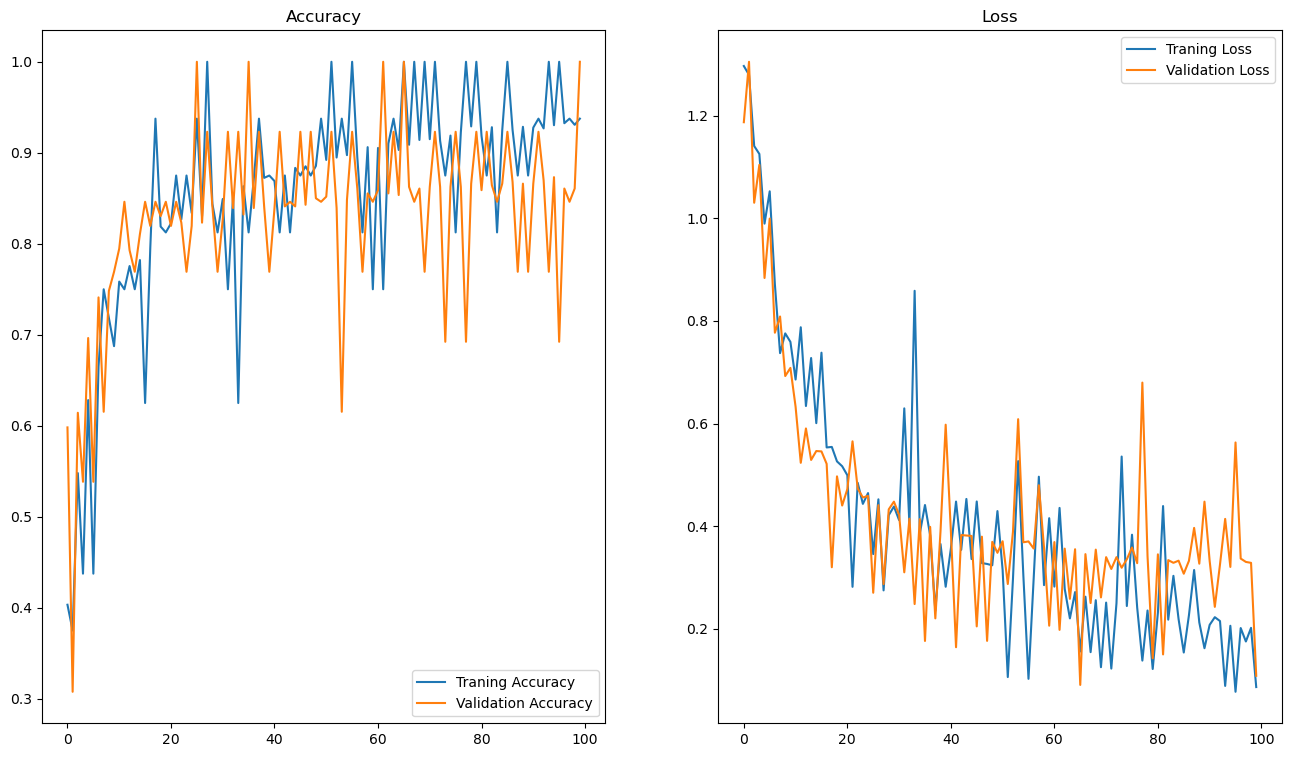

In [46]:


plt.figure(figsize=(16,9))

epochs = range(len(history.history['accuracy']))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label="Traning Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label="Traning Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Loss")
plt.legend()

In [47]:
import numpy as np

test_generator = test_datagen.flow_from_directory(
    "./" + test_dir,
    target_size=(400, 400),
    batch_size=16,
    class_mode="categorical",
    shuffle=False
)

predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)

predicted_classes = predictions.argmax(axis=-1)

test_loss, test_accuracy, *_ = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")





Found 394 images belonging to 4 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4933 - loss: 2.1506 - mse: 0.2030
Test Accuracy: 69.79%


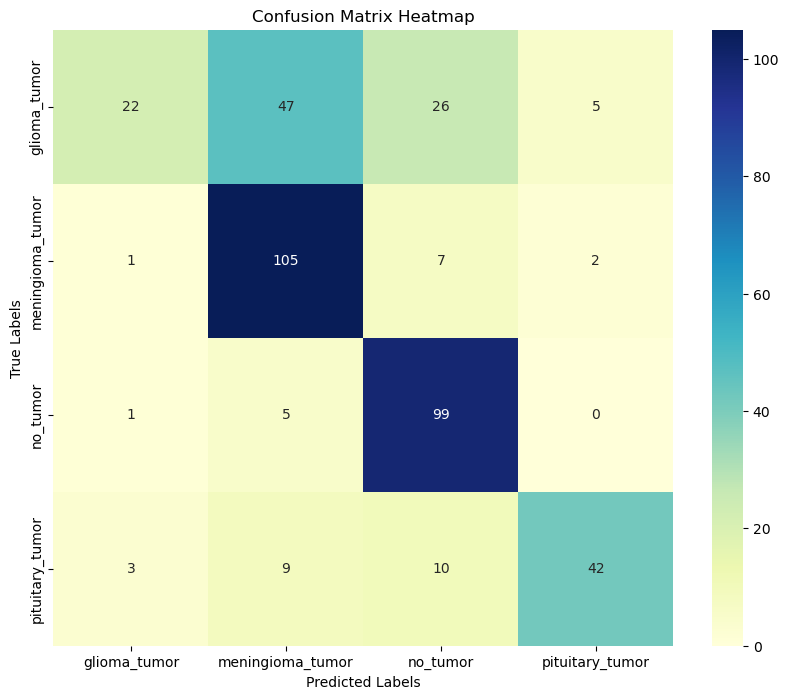

In [48]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_labels[:len(predicted_classes)], predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [49]:
print(classification_report(true_labels[:len(predicted_classes)], predicted_classes))

              precision    recall  f1-score   support

           0       0.81      0.22      0.35       100
           1       0.63      0.91      0.75       115
           2       0.70      0.94      0.80       105
           3       0.86      0.66      0.74        64

    accuracy                           0.70       384
   macro avg       0.75      0.68      0.66       384
weighted avg       0.74      0.70      0.66       384

